In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display

import os
import IPython.display as ipd

from data import get_features

from model import get_model

c:\soft\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
N_HARM = 14
N_CAND = 100
SEQ_LEN = 16
BATCH_SIZE = 1
N_HIDDEN = 16
PADDING = 'SAME'

SR = 16000
RNN_STRIDE = 1

In [3]:
# with open('sample_2.pcm', 'rb') as f:
#     raw_data = f.read()
#     signal = np.frombuffer(raw_data, dtype=np.int16)

In [4]:
filepath = 'D:\\VAD-dataset\\Examples\\_79153725920-2018.01.21_00-28_.wav'
# filepath = 'generated.wav'

signal, _, = librosa.load(filepath, sr=SR)
signal = signal[5*SR:10*SR]
ipd.Audio(signal, rate=SR)

In [5]:
features = get_features(signal=signal, n_cand=N_CAND)

In [6]:
def batch_iterator(features):
    padded_features = np.pad(features, ((SEQ_LEN, 0), (0, 0), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
    n_samples = padded_features.shape[0] - SEQ_LEN + 1

    for i in range(n_samples):
        batch_features = padded_features[i:i+SEQ_LEN]
        batch_features = batch_features[np.newaxis, ...]
        yield batch_features

In [7]:
ckpt = tf.train.get_checkpoint_state('trained_model/base')
path_to_model = os.path.join('trained_model/base', 'model.ckpt-499999')

In [8]:
mean_std = np.load('mean-std.npz')

mean = np.mean(mean_std['mean'][np.newaxis, np.newaxis, ...], axis=2, keepdims=True)
std = np.std(mean_std['std'][np.newaxis, np.newaxis, ...], axis=2, keepdims=True)

mean = tf.constant(mean, name='mean')
std = tf.constant(std, name='std')

In [9]:
model = {}
model['N_HIDDEN'] = N_HIDDEN
model['N_CAND'] = N_CAND
model['SEQ_LEN'] = SEQ_LEN
model['BATCH_SIZE'] = BATCH_SIZE
model['RNN_STRIDE'] = RNN_STRIDE
model['PADDING'] = PADDING

In [10]:
features_phr = tf.placeholder(tf.float32, [None, SEQ_LEN, N_CAND, N_HARM], name='inputs/features')
(rnn_preds, cnn_preds), (rnn_acts, cnn_acts) = get_model(features_phr, model, mean, std, is_training=False, return_activations=True)
saver = tf.train.Saver()

sess = tf.Session()
saver.restore(sess, path_to_model)

INFO:tensorflow:Restoring parameters from trained_model/base\model.ckpt-499999


In [11]:
batch = batch_iterator(features)

results = []

for batch_features in batch:
    result = sess.run([rnn_preds, cnn_preds, rnn_acts, cnn_acts], 
                      feed_dict={features_phr: batch_features})
    results.append(result)

In [12]:
_rnn_output, _cnn_output, _rnn_activation, _cnn_actuvation = zip(*results)

In [13]:
np.array(_rnn_activation).shape

(622, 1, 100, 1)

In [14]:
_cnn_actuvation = np.array(_cnn_actuvation).reshape(-1, N_CAND, 1)
_rnn_activation = np.array(_rnn_activation).reshape(-1, 100, 1)
_cnn_output = np.array(_cnn_output)[..., 0]
_rnn_output = np.array(_rnn_output)

In [15]:
# spectrogram = librosa.feature.melspectrogram(signal, sr=SR, n_fft=512, hop_length=128)
spectrogram = librosa.core.stft(signal, hop_length=128, n_fft=512)
spectrogram = np.abs(spectrogram)
CUT_OFF = 4000
FFT_STEP = 16000 / 512
n_env = int(CUT_OFF // FFT_STEP)

spectrogram = spectrogram[:n_env]

In [16]:
new_tick_locations = np.linspace(0, 1, 10)
tick_labels = ['%.2f' % f for f in np.linspace(70, 350, 10)]

c:\soft\python36\lib\site-packages\librosa\display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


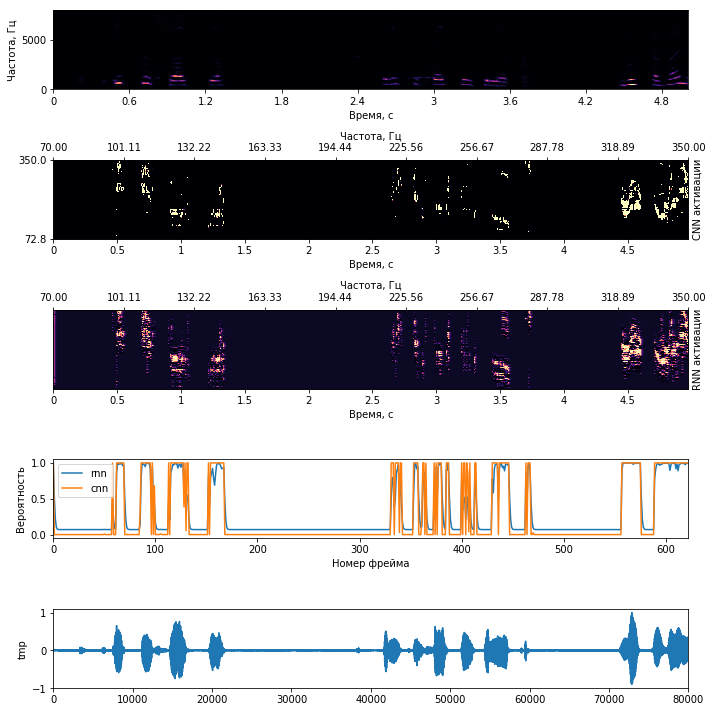

In [17]:
clip_size = 0
start_clip = 100
plt.figure(figsize=(10, 10))

subplots = 5
plt.subplot(subplots, 1, 1)
librosa.display.specshow(spectrogram, y_axis='linear', fmin=70, x_axis='time', sr=SR, hop_length=128)
plt.xlabel('Время, с')
plt.ylabel('Частота, Гц')

plt.subplot(subplots, 1, 2)
ax1 = librosa.display.specshow(_cnn_actuvation[:, :, 0].T,  y_axis='mel', fmin=70, fmax=350, x_axis='time', sr=SR, hop_length=128)
ax1.set_xlabel('Время, с')
ax1.yaxis.set_label_position("right")
ax1.set_ylabel('CNN активации')

ax2 = ax1.twiny()
ax2.set_xticks(new_tick_locations)
ax2.set_xlabel('Частота, Гц')
ax2.set_xticklabels(tick_labels)

plt.subplot(subplots, 1, 3)
# plt.title('Активации RNN')
# plt.imshow(_rnn_activation[:500, ::-1, 0].T)
ax1 = librosa.display.specshow(_rnn_activation[:, :, 0].T, sr=SR, hop_length=128, y_axis='off', fmin=70, fmax=350, x_axis='time')
ax1.set_xlabel('Время, с')
ax1.yaxis.set_label_position("right")
ax1.set_ylabel('RNN активации')


ax2 = ax1.twiny()
ax2.set_xticks(new_tick_locations)
ax2.set_xlabel('Частота, Гц')
ax2.set_xticklabels(tick_labels)

plt.subplot(subplots, 1, 4)
rnn_output_array = _rnn_output.flatten()
plt.plot(rnn_output_array, label='rnn')
# plt.plot((rnn_output_array[start_clip:clip_size] > 0.5).astype(np.float32), label='rnn')

# cnn_output_array = np.array(_cnn_output).reshape(107, 128, 16, -1)
cnn_output_array = _cnn_output.flatten()
plt.plot(cnn_output_array, label='cnn')
# plt.plot((cnn_output_array[start_clip:clip_size] > 0.5).astype(np.float32), label='cnn')
# plt.subplots_adjust(left=0.0, right=0.0)
plt.xlim(0, len(cnn_output_array))
plt.xlabel('Номер фрейма')
plt.ylabel('Вероятность')
plt.legend()
plt.subplot(subplots, 1, 5)
plt.plot(signal / signal.max())
plt.ylabel('tmp')
plt.xlim(0, len(signal))
plt.tight_layout()

plt.savefig('result.png')

In [18]:
weigths = sess.run(tf.trainable_variables()[0])

In [19]:
weigths = weigths[0, 0]

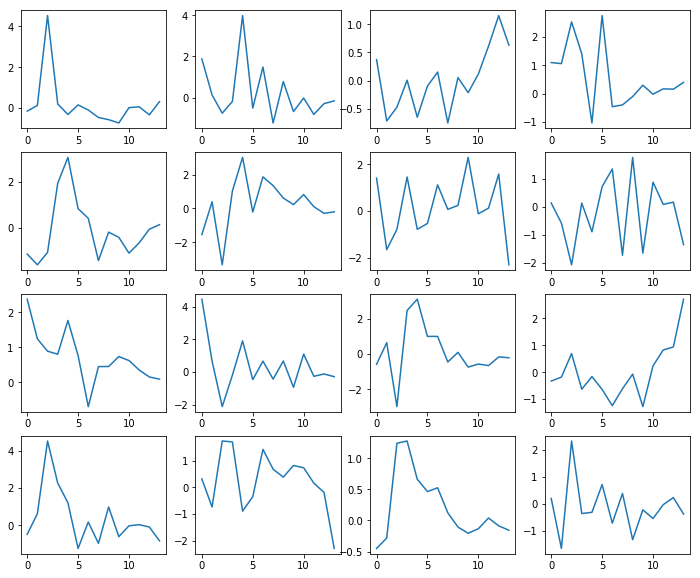

In [20]:
plt.figure(figsize=(12, 10))
for i in range(weigths.shape[-1]):
    plt.subplot(4, 4, i+1)
    plt.plot(weigths[:, i])